In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.path)
from eigenwell.src import grid, eigen_k, eigen_w
from eigenwell.src.constants import *

['/Users/nathanzhao/src/eigenwell/notebooks', '/Users/nathanzhao/src', '/Users/nathanzhao/opt/anaconda3/lib/python38.zip', '/Users/nathanzhao/opt/anaconda3/lib/python3.8', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/nathanzhao/src/ceviche', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/nathanzhao/.ipython']


(80, 80)
(6400, 6400)


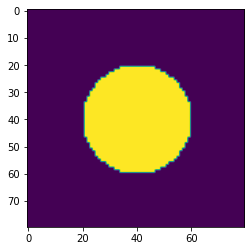

In [2]:
Nx = 80;
Ny = 80;
N = np.array([Nx, Ny]);

eps_r = np.ones(N);

a = np.array([1,1]);
dL = a/N;
radius = 0.25;
## put in a circle;
ci = int(Nx/2); cj= int(Ny/2);

cr = (radius/a[0])*Nx;
I,J=np.meshgrid(np.arange(eps_r.shape[0]),np.arange(eps_r.shape[1]));

print(eps_r.shape)
dist = np.sqrt((I-ci)**2 + (J-cj)**2);
#print(np.where(dist<cr))
eps_r[np.where(dist<cr)] = 6;

plt.imshow(eps_r)
wvlen_scan = np.linspace(1.01, 20, 100);
wvlen_scan = np.logspace(np.log10(0.8), np.log10(10), 600);


fd = grid.FiniteDifference(dL,N)

print(fd.Dxf.shape)



In [3]:
eign2d = eigen_w.EigenOmega2D(eps_r, fd);

[-1.24723939e+05+0.j  1.43511867e+18+0.j  2.56190752e+18+0.j
  3.16615133e+18+0.j  1.40815023e+18+0.j  1.40815023e+18+0.j
  4.12406066e+18+0.j  5.28768759e+18+0.j  4.58067095e+18+0.j
  4.58067095e+18+0.j]


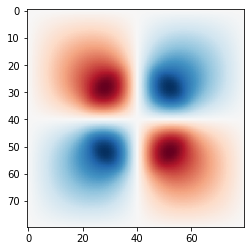

In [4]:
print(eign2d)

eigenvals, eigenvecs = eign2d.eigensolve(num_modes = 10)

print(eigenvals)

plt.imshow(np.real(np.reshape(eigenvecs[:,3], N)), cmap = 'RdBu')

## Photonic Band Structure
#### Ky = 0

In [16]:
eigk = eigen_k.EigenK2D(eps_r, fd)
print(fd.Dxf.shape)


(6400, 6400)


In [12]:
Ky = 0;
wvlen = 1e-6;
omega = 2*np.pi*C0/(wvlen/1e-6);
eigvals, eigvecs = eigk.eigensolve(omega, Ky)
plt.imshow(np.real(np.reshape(eigenvecs[:,5], N)), cmap = 'RdBu')

In [24]:
wvlen_scan = np.linspace(1,10,60);
wvlen_scan = np.logspace(np.log10(1), np.log10(10),200)
spectra = [];
for c,wvlen in enumerate(wvlen_scan):
    omega = 2*np.pi*C0/(wvlen);
    eigvals, eigvecs = eigk.eigensolve(omega, Ky, num_modes = 3)
    spectra.append(eigvals);
    if(c%5 == 0):
        print(c, wvlen)
spectra = np.array(spectra)

/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


0 1.0
5 1.059560179277616
10 1.1226677735108137
15 1.1895340673703196
20 1.2603829296797275
25 1.3354515629298989
30 1.414991297434576
35 1.4992684327860457
40 1.5885651294280527
45 1.6831803533309568
50 1.7834308769319094
55 1.88965233969121
60 2.0022003718155847
65 2.1214517849106302
70 2.2478058335487257
75 2.3816855519761586
80 2.5235391704347663
85 2.673841615839947
90 2.8330961018393244
95 3.0018358135755894
100 3.180625692794119
105 3.370064329271928
110 3.5707859649004634
115 3.78346261713193
120 4.008806328898466
125 4.2475715525368996
130 4.500557675700499
135 4.768611697714471
140 5.052631065335681
145 5.353566677410726
150 5.672426068491979
155 6.010276782070384
160 6.368249944718588
165 6.747544053110695
170 7.149428986597579
175 7.575250258771915
180 8.026433522257175
185 8.50448934180268
190 9.011018251665021
195 9.54771611420806


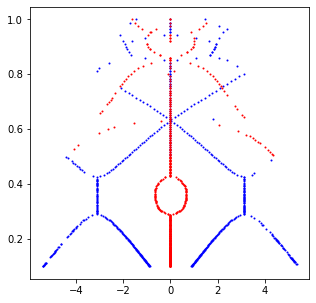

In [25]:
plt.figure(figsize = (5,5));
plt.plot(np.real(spectra), 1/wvlen_scan, '.b', markersize = 2);
plt.plot(np.imag(spectra),  1/wvlen_scan, '.r', markersize = 2);
#plt.xlim((-30e6, 50e6))
plt.show();
